In [2]:
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import boto3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import json
import os

In [4]:

# --- CONFIGURATION ---
# IMPORTANT: Update these with your details
BUCKET_NAME = ""  # The bucket where you exported your DynamoDB data
# The folder inside the bucket. It will look like 'AWSDynamoDB/01752.../'
# Go to your S3 bucket to find the exact path.
S3_FOLDER_PATH = "" 
OUTPUT_IMAGE_DIR = "analysis_results" # A local folder to save the plots


aws_access_key_id = ''
aws_secret_access_key = ''
aws_region = 'us-east-1'



In [7]:

# --- Step 1: Download Data from S3 ---

# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_IMAGE_DIR):
    os.makedirs(OUTPUT_IMAGE_DIR)

#s3 = boto3.client('s3')
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name=aws_region
)
paginator = s3.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket=BUCKET_NAME, Prefix=S3_FOLDER_PATH)


all_data = []
print(f"Fetching data from s3://{BUCKET_NAME}/{S3_FOLDER_PATH}...")

for page in pages:
    for obj in page.get('Contents', []):
        if obj['Key'].endswith('.json.gz'): # DynamoDB exports are gzipped
            response = s3.get_object(Bucket=BUCKET_NAME, Key=obj['Key'])
            # The content is gzipped, so we need to decompress it
            import gzip
            content = gzip.decompress(response['Body'].read()).decode('utf-8')
            
            # Each line in the file is a separate JSON object
            for line in content.splitlines():
                if line.strip():
                    # DynamoDB JSON has a specific structure, e.g., {"Item": {...}}
                    item_data = json.loads(line).get("Item", {})
                    # Flatten the structure, e.g., from {"author": {"S": "username"}} to {"author": "username"}
                    flat_item = {k: list(v.values())[0] for k, v in item_data.items()}
                    all_data.append(flat_item)

print(f"Successfully downloaded and parsed {len(all_data)} records.")


Fetching data from s3://hasan-reddit-comments-raw-data/AWSDynamoDB/01752761367686-748c12c4/...
Successfully downloaded and parsed 433 records.



--- DataFrame Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 433 entries, 0 to 432
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   comment_id        433 non-null    object 
 1   comment_body      433 non-null    object 
 2   prediction_label  433 non-null    object 
 3   prediction_score  433 non-null    float64
 4   subreddit         433 non-null    object 
 5   author            433 non-null    object 
 6   created_utc       433 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 23.8+ KB

--- DataFrame Head ---
  comment_id                                       comment_body  \
0    n3hzk01  So Lurch Voldemort and Dr. Evil walk into an A...   
1    n3icoff  It’s not but it is kinda funny to see how deta...   
2    n3i72ap             Congratulations you’ve lost your base!   
3    n3i1qmt  So we've been playing this game for a week now...   
4    n3i9xbh               

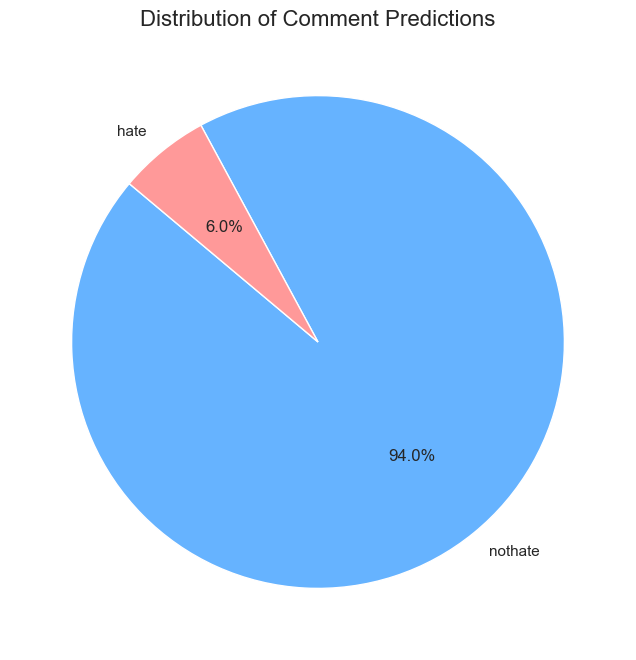

Pie chart saved to analysis_results/prediction_pie_chart.png

Generating word cloud...


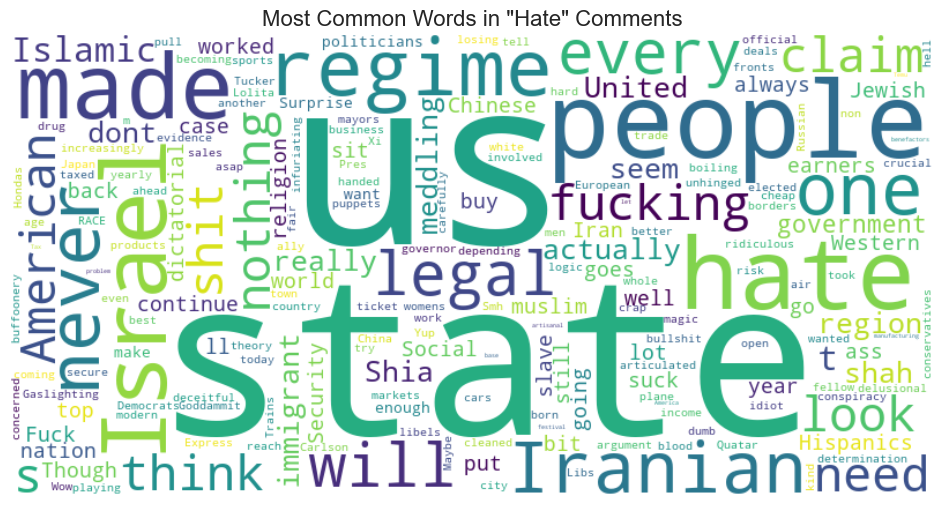

Word cloud saved to analysis_results/hate_word_cloud.png

Generating table of top hateful comments...


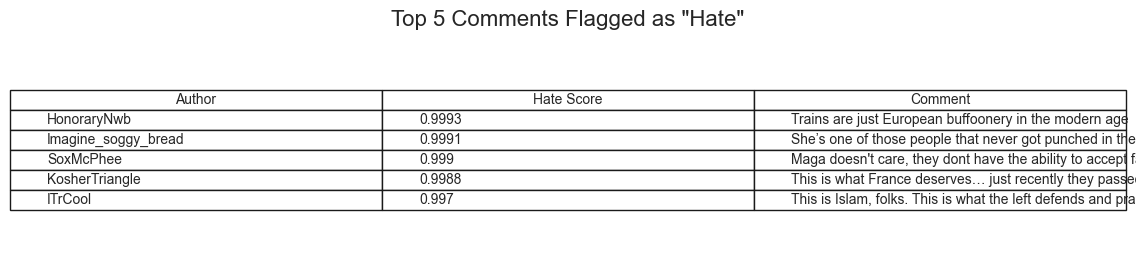

Table image saved to analysis_results/top_hateful_comments.png


In [8]:


# --- Step 2: Load Data into a Pandas DataFrame ---

if not all_data:
    print("No data found. Exiting.")
else:
    df = pd.DataFrame(all_data)
    
    # Convert numeric columns from string to number
    df['prediction_score'] = pd.to_numeric(df['prediction_score'], errors='coerce')
    df['created_utc'] = pd.to_numeric(df['created_utc'], errors='coerce')
    
    print("\n--- DataFrame Info ---")
    df.info()
    
    print("\n--- DataFrame Head ---")
    print(df.head())


    # --- Step 3: Create and Save Visualizations ---

    # Set a professional plot style
    sns.set_theme(style="whitegrid")

    # Visual 1: Hate vs. Non-Hate Pie Chart
    print("\nGenerating pie chart...")
    plt.figure(figsize=(8, 8))
    label_counts = df['prediction_label'].value_counts()
    plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
    plt.title('Distribution of Comment Predictions', fontsize=16)
    plt.ylabel('') # Hide the 'prediction_label' y-axis label
    pie_chart_path = os.path.join(OUTPUT_IMAGE_DIR, 'prediction_pie_chart.png')
    plt.savefig(pie_chart_path)
    plt.show()
    print(f"Pie chart saved to {pie_chart_path}")

    # Visual 2: Word Cloud of Hateful Comments
    print("\nGenerating word cloud...")
    hateful_comments_df = df[df['prediction_label'] == 'hate']
    
    if not hateful_comments_df.empty:
        text = " ".join(comment for comment in hateful_comments_df.comment_body)
        
        # Add common words to the stopwords list to make the cloud more meaningful
        stopwords = set(STOPWORDS)
        stopwords.update(["https", "http", "www", "com", "reddit", "post", "comment", "thread"])
        
        wordcloud = WordCloud(stopwords=stopwords, background_color="white", width=800, height=400).generate(text)
        
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title('Most Common Words in "Hate" Comments', fontsize=16)
        wordcloud_path = os.path.join(OUTPUT_IMAGE_DIR, 'hate_word_cloud.png')
        plt.savefig(wordcloud_path)
        plt.show()
        print(f"Word cloud saved to {wordcloud_path}")
    else:
        print("No 'hate' comments found to generate a word cloud.")

    # Visual 3: Table of Top Hateful Comments (as a saved image)
    print("\nGenerating table of top hateful comments...")
    top_hateful = hateful_comments_df.sort_values(by='prediction_score', ascending=False).head(5)
    
    if not top_hateful.empty:
        fig, ax = plt.subplots(figsize=(12, 3)) 
        ax.axis('tight')
        ax.axis('off')
        table = ax.table(cellText=top_hateful[['author', 'prediction_score', 'comment_body']].values, 
                         colLabels=['Author', 'Hate Score', 'Comment'], 
                         loc='center', cellLoc='left')
        table.auto_set_font_size(False)
        table.set_fontsize(10)
        table.scale(1.2, 1.2)
        plt.title('Top 5 Comments Flagged as "Hate"', fontsize=16, y=1.0)
        table_path = os.path.join(OUTPUT_IMAGE_DIR, 'top_hateful_comments.png')
        plt.savefig(table_path, bbox_inches='tight', pad_inches=0.1)
        plt.show()
        print(f"Table image saved to {table_path}")
    else:
        print("No 'hate' comments found to generate a table.")



In [10]:
df

,comment_id,comment_body,prediction_label,prediction_score,subreddit,author,created_utc
0,n3hzk01,So Lurch Voldemort and Dr. Evil walk into an A...,nothate,0.9954,Conservative,D_Ethan_Bones,1752694256
1,n3icoff,It’s not but it is kinda funny to see how deta...,nothate,0.9998,Conservative,DoItForDale2,1752697938
2,n3i72ap,Congratulations you’ve lost your base!,nothate,0.9999,Conservative,Icy-Independence5737,1752696410
3,n3i1qmt,So we've been playing this game for a week now...,nothate,0.9199,Conservative,Texas103,1752694869
4,n3i9xbh,Exactly.,nothate,0.9994,Conservative,Right_Independent_71,1752697198
...,...,...,...,...,...,...,...
428,n3i4imp,(Lol),nothate,0.9993,Conservative,CanaryJane42,1752695694
429,n3hy3u3,It wasn't biden. Stop it.put the blame where ...,nothate,0.9862,Conservative,kruselm1,1752693853
430,n3i69w2,Idk the Ridgeline i believe is exclusively mad...,nothate,0.9999,Conservative,Omecore65,1752696187
431,n3htxt5,"Trump's a pretty smart guy, and a genius at ce...",nothate,0.9988,Conservative,ElydthiaUaDanann,1752692678
